In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import matthews_corrcoef, accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
#from sklearn import LogisticRegression

In [2]:
### Preparing DATA
# Load dataset into a pandas dataframe
df = pd.read_csv('final.txt')
df['pdb_id'] = df['pair'].apply(lambda x: x.split('_')[0])
df = df.rename(columns={'pdockq1': 'pdockq2', 'pdockq2': 'pdockq1'})

# Make it binary by setting a threshold and split training and test
#df['binary_obs_contact'] = np.where(df['obs_contact'] > 20, 1, 0)  # change here if necessary
df.columns

Index(['IntraclashesGroup1', 'IntraclashesGroup2', 'Interaction Energy',
       'Backbone Hbond', 'Sidechain Hbond', 'Van der Waals', 'Electrostatics',
       'Solvation Polar', 'Solvation Hydrophobic', 'Van der Waals clashes',
       'entropy sidechain', 'entropy mainchain', 'sloop_entropy',
       'mloop_entropy', 'cis_bond', 'torsional clash', 'backbone clash',
       'helix dipole', 'water bridge', 'disulfide', 'electrostatic kon',
       'partial covalent bonds', 'energy Ionisation', 'Entropy Complex',
       'Number of Residues', 'Interface Residues',
       'Interface Residues Clashing', 'Interface Residues VdW Clashing',
       'Interface Residues BB Clashing', 'pair', 'obs_contact', 'pred_contact',
       'pdockq2', 'pdockq1', 'ptm_iptm', 'pdb_id'],
      dtype='object')

In [5]:
#df[(df['pred_contact']<df['Interface Residues']) & (df['obs_contact']>25)]
#df[(df['pred_contact']<df['Interface Residues'])]['pred_contact'].describe()
#df['Interaction Energy'].describe()

In [3]:
def get_tp_tn_fp_fn(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp, tn, fp, fn
def safe_mcc(y_true, y_pred):
    eps = np.finfo(np.float64).eps # smallest representable positive number
    tp, tn, fp, fn = get_tp_tn_fp_fn(y_true, y_pred) # function to calculate tp, tn, fp, fn
    denom = np.sqrt((tp + fp + eps) * (tp + fn + eps) * (tn + fp + eps) * (tn + fn + eps))
    return (tp * tn - fp * fn) / denom

In [4]:
thresholds_features_dic = {}
for threshold in [0,10]:
    df['binary_obs_contact'] = np.where(df['obs_contact'] > threshold, 1, 0)  # change here if necessary

    ranked_df=pd.DataFrame()

    # Make it binary by setting a threshold and split training and test
    ranked_df['binary_obs_contact'] = df['binary_obs_contact']

    # Generate a random feature
    ranked_df['random1'] = np.random.randint(low=1, high=1370, size=1370)
    ranked_df['random2'] = np.random.randint(low=1, high=1370, size=1370)
    ranked_df['random3'] = np.random.randint(low=1, high=1370, size=1370)
    ranked_df['random4'] = np.random.randint(low=1, high=1370, size=1370)
    ranked_df['random5'] = np.random.randint(low=1, high=1370, size=1370)
    ranked_df['random6'] = np.random.randint(low=1, high=1370, size=1370)
    ranked_df['random7'] = np.random.randint(low=1, high=1370, size=1370)

    features_dic = {}
    thresholds_dic = {}
    for feature in ['random1','random2','random3','random4','random5','random6','random7',\
                    'IntraclashesGroup1', 'IntraclashesGroup2', 'Interaction Energy',
           'Backbone Hbond', 'Sidechain Hbond', 'Van der Waals', 'Electrostatics',
           'Solvation Polar', 'Solvation Hydrophobic', 'Van der Waals clashes',
           'entropy sidechain', 'entropy mainchain', 'sloop_entropy',
           'mloop_entropy', 'cis_bond', 'torsional clash', 'backbone clash',
           'helix dipole', 'water bridge', 'disulfide', 'electrostatic kon',
           'partial covalent bonds', 'energy Ionisation', 'Entropy Complex',
           'Number of Residues', 'Interface Residues',
           'Interface Residues Clashing', 'Interface Residues VdW Clashing',
           'Interface Residues BB Clashing', 'pred_contact',
           'pdockq1', 'pdockq2', 'ptm_iptm']:

        if feature[:6] != 'random':
            ranked_df[feature] = df[feature].rank()

        # Check the correlation
        if np.corrcoef(ranked_df['binary_obs_contact'],ranked_df[feature])[0][1] > 0:
            # Compute F1 score for different threshold values
            thresholds = [i for i in range(1, 1370)]
            f1_scores = []
            for t in thresholds:
                y_pred_binary = (ranked_df[feature] >= t).astype(int)
                MCC = safe_mcc(ranked_df['binary_obs_contact'], y_pred_binary)
                f1_scores.append(MCC)
            # Find the threshold that maximizes F1 score
            best_threshold = thresholds[f1_scores.index(max(f1_scores))]
            y_pred_binary = (ranked_df[feature] >= best_threshold).astype(int)
            print (feature)
            print ('MCC: ',safe_mcc(ranked_df['binary_obs_contact'], y_pred_binary))
            print (confusion_matrix(ranked_df['binary_obs_contact'], y_pred_binary))
            print (classification_report(ranked_df['binary_obs_contact'], y_pred_binary))
            #print("Best threshold:", best_threshold)
            #print("Best macro f1:", max(f1_scores))
            print ('\n')
            thresholds_dic[feature]=[best_threshold,1]

        else:
            # Compute F1 score for different threshold values
            thresholds = [i for i in range(1, 1370)]
            f1_scores = []
            for t in thresholds:
                y_pred_binary = (ranked_df[feature] <= t).astype(int)
                MCC = safe_mcc(ranked_df['binary_obs_contact'], y_pred_binary)
                f1_scores.append(MCC)
            # Find the threshold that maximizes F1 score
            best_threshold = thresholds[f1_scores.index(max(f1_scores))]
            y_pred_binary = (ranked_df[feature] <= best_threshold).astype(int)
            print (feature)
            print ('MCC: ',safe_mcc(ranked_df['binary_obs_contact'], y_pred_binary))
            print (confusion_matrix(ranked_df['binary_obs_contact'], y_pred_binary))
            print (classification_report(ranked_df['binary_obs_contact'], y_pred_binary))
            #print("Best threshold:", best_threshold)
            #print("Best macro f1 score:", max(f1_scores))
            print ('\n')
            thresholds_dic[feature]=[best_threshold,-1]
        features_dic[feature]=safe_mcc(ranked_df['binary_obs_contact'], y_pred_binary)

    features_dic['random']=np.mean([features_dic['random1'],features_dic['random2'],features_dic['random3'],features_dic['random4'],features_dic['random5'],features_dic['random6'],features_dic['random7']])
    del features_dic['random1']; del features_dic['random2']; del features_dic['random3']; del features_dic['random4']; del features_dic['random5']; del features_dic['random6']; del features_dic['random7']
    thresholds_features_dic[threshold]=features_dic

random1
MCC:  0.07187637744526075
[[111 299]
 [197 763]]
              precision    recall  f1-score   support

           0       0.36      0.27      0.31       410
           1       0.72      0.79      0.75       960

    accuracy                           0.64      1370
   macro avg       0.54      0.53      0.53      1370
weighted avg       0.61      0.64      0.62      1370



random2
MCC:  0.04407570034098635
[[226 184]
 [483 477]]
              precision    recall  f1-score   support

           0       0.32      0.55      0.40       410
           1       0.72      0.50      0.59       960

    accuracy                           0.51      1370
   macro avg       0.52      0.52      0.50      1370
weighted avg       0.60      0.51      0.53      1370



random3
MCC:  0.053143298162639775
[[410   0]
 [951   9]]
              precision    recall  f1-score   support

           0       0.30      1.00      0.46       410
           1       1.00      0.01      0.02       960

    ac

O:\anaconda3\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
O:\anaconda3\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


sloop_entropy
MCC:  0.0
[[410   0]
 [960   0]]
              precision    recall  f1-score   support

           0       0.30      1.00      0.46       410
           1       0.00      0.00      0.00       960

    accuracy                           0.30      1370
   macro avg       0.15      0.50      0.23      1370
weighted avg       0.09      0.30      0.14      1370





O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\numpy\lib\function_b

mloop_entropy
MCC:  0.0
[[410   0]
 [960   0]]
              precision    recall  f1-score   support

           0       0.30      1.00      0.46       410
           1       0.00      0.00      0.00       960

    accuracy                           0.30      1370
   macro avg       0.15      0.50      0.23      1370
weighted avg       0.09      0.30      0.14      1370





O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


cis_bond
MCC:  0.06143233882340551
[[410   0]
 [948  12]]
              precision    recall  f1-score   support

           0       0.30      1.00      0.46       410
           1       1.00      0.01      0.02       960

    accuracy                           0.31      1370
   macro avg       0.65      0.51      0.24      1370
weighted avg       0.79      0.31      0.16      1370



torsional clash
MCC:  0.05828646216059478
[[181 229]
 [364 596]]
              precision    recall  f1-score   support

           0       0.33      0.44      0.38       410
           1       0.72      0.62      0.67       960

    accuracy                           0.57      1370
   macro avg       0.53      0.53      0.52      1370
weighted avg       0.61      0.57      0.58      1370



backbone clash
MCC:  0.16470736762331276
[[ 61 349]
 [ 49 911]]
              precision    recall  f1-score   support

           0       0.55      0.15      0.23       410
           1       0.72      0.95      0.82   

O:\anaconda3\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
O:\anaconda3\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


water bridge
MCC:  0.0
[[410   0]
 [960   0]]
              precision    recall  f1-score   support

           0       0.30      1.00      0.46       410
           1       0.00      0.00      0.00       960

    accuracy                           0.30      1370
   macro avg       0.15      0.50      0.23      1370
weighted avg       0.09      0.30      0.14      1370





O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


disulfide
MCC:  0.06753226692367863
[[408   2]
 [936  24]]
              precision    recall  f1-score   support

           0       0.30      1.00      0.47       410
           1       0.92      0.03      0.05       960

    accuracy                           0.32      1370
   macro avg       0.61      0.51      0.26      1370
weighted avg       0.74      0.32      0.17      1370



electrostatic kon
MCC:  0.1559317898541325
[[190 220]
 [289 671]]
              precision    recall  f1-score   support

           0       0.40      0.46      0.43       410
           1       0.75      0.70      0.73       960

    accuracy                           0.63      1370
   macro avg       0.57      0.58      0.58      1370
weighted avg       0.65      0.63      0.64      1370





O:\anaconda3\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
O:\anaconda3\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


partial covalent bonds
MCC:  0.0
[[410   0]
 [960   0]]
              precision    recall  f1-score   support

           0       0.30      1.00      0.46       410
           1       0.00      0.00      0.00       960

    accuracy                           0.30      1370
   macro avg       0.15      0.50      0.23      1370
weighted avg       0.09      0.30      0.14      1370





O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


energy Ionisation
MCC:  0.07156485842624102
[[341  69]
 [737 223]]
              precision    recall  f1-score   support

           0       0.32      0.83      0.46       410
           1       0.76      0.23      0.36       960

    accuracy                           0.41      1370
   macro avg       0.54      0.53      0.41      1370
weighted avg       0.63      0.41      0.39      1370





O:\anaconda3\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
O:\anaconda3\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Entropy Complex
MCC:  0.0
[[410   0]
 [960   0]]
              precision    recall  f1-score   support

           0       0.30      1.00      0.46       410
           1       0.00      0.00      0.00       960

    accuracy                           0.30      1370
   macro avg       0.15      0.50      0.23      1370
weighted avg       0.09      0.30      0.14      1370





O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Number of Residues
MCC:  0.16272897992166852
[[140 270]
 [183 777]]
              precision    recall  f1-score   support

           0       0.43      0.34      0.38       410
           1       0.74      0.81      0.77       960

    accuracy                           0.67      1370
   macro avg       0.59      0.58      0.58      1370
weighted avg       0.65      0.67      0.66      1370



Interface Residues
MCC:  0.08788467943149807
[[108 302]
 [178 782]]
              precision    recall  f1-score   support

           0       0.38      0.26      0.31       410
           1       0.72      0.81      0.77       960

    accuracy                           0.65      1370
   macro avg       0.55      0.54      0.54      1370
weighted avg       0.62      0.65      0.63      1370



Interface Residues Clashing
MCC:  0.17901503575320385
[[362  48]
 [689 271]]
              precision    recall  f1-score   support

           0       0.34      0.88      0.50       410
           1       0

Van der Waals
MCC:  0.1054643514147217
[[ 15 558]
 [  2 795]]
              precision    recall  f1-score   support

           0       0.88      0.03      0.05       573
           1       0.59      1.00      0.74       797

    accuracy                           0.59      1370
   macro avg       0.73      0.51      0.40      1370
weighted avg       0.71      0.59      0.45      1370



Electrostatics
MCC:  0.13742370958995712
[[570   3]
 [752  45]]
              precision    recall  f1-score   support

           0       0.43      0.99      0.60       573
           1       0.94      0.06      0.11       797

    accuracy                           0.45      1370
   macro avg       0.68      0.53      0.35      1370
weighted avg       0.73      0.45      0.31      1370



Solvation Polar
MCC:  0.09391833060544137
[[119 454]
 [109 688]]
              precision    recall  f1-score   support

           0       0.52      0.21      0.30       573
           1       0.60      0.86      0.7

O:\anaconda3\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
O:\anaconda3\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


sloop_entropy
MCC:  0.0
[[573   0]
 [797   0]]
              precision    recall  f1-score   support

           0       0.42      1.00      0.59       573
           1       0.00      0.00      0.00       797

    accuracy                           0.42      1370
   macro avg       0.21      0.50      0.29      1370
weighted avg       0.17      0.42      0.25      1370





O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\numpy\lib\function_b

mloop_entropy
MCC:  0.0
[[573   0]
 [797   0]]
              precision    recall  f1-score   support

           0       0.42      1.00      0.59       573
           1       0.00      0.00      0.00       797

    accuracy                           0.42      1370
   macro avg       0.21      0.50      0.29      1370
weighted avg       0.17      0.42      0.25      1370





O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


cis_bond
MCC:  0.07970560972115001
[[573   0]
 [785  12]]
              precision    recall  f1-score   support

           0       0.42      1.00      0.59       573
           1       1.00      0.02      0.03       797

    accuracy                           0.43      1370
   macro avg       0.71      0.51      0.31      1370
weighted avg       0.76      0.43      0.27      1370



torsional clash
MCC:  0.06265235599692388
[[ 41 532]
 [ 34 763]]
              precision    recall  f1-score   support

           0       0.55      0.07      0.13       573
           1       0.59      0.96      0.73       797

    accuracy                           0.59      1370
   macro avg       0.57      0.51      0.43      1370
weighted avg       0.57      0.59      0.48      1370



backbone clash
MCC:  0.13869029982449219
[[ 72 501]
 [ 39 758]]
              precision    recall  f1-score   support

           0       0.65      0.13      0.21       573
           1       0.60      0.95      0.74   

O:\anaconda3\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
O:\anaconda3\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


water bridge
MCC:  0.0
[[573   0]
 [797   0]]
              precision    recall  f1-score   support

           0       0.42      1.00      0.59       573
           1       0.00      0.00      0.00       797

    accuracy                           0.42      1370
   macro avg       0.21      0.50      0.29      1370
weighted avg       0.17      0.42      0.25      1370





O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


disulfide
MCC:  0.05603221536238634
[[564   9]
 [770  27]]
              precision    recall  f1-score   support

           0       0.42      0.98      0.59       573
           1       0.75      0.03      0.06       797

    accuracy                           0.43      1370
   macro avg       0.59      0.51      0.33      1370
weighted avg       0.61      0.43      0.29      1370



electrostatic kon
MCC:  0.18379806578942223
[[276 297]
 [240 557]]
              precision    recall  f1-score   support

           0       0.53      0.48      0.51       573
           1       0.65      0.70      0.67       797

    accuracy                           0.61      1370
   macro avg       0.59      0.59      0.59      1370
weighted avg       0.60      0.61      0.60      1370





O:\anaconda3\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
O:\anaconda3\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


partial covalent bonds
MCC:  0.0
[[573   0]
 [797   0]]
              precision    recall  f1-score   support

           0       0.42      1.00      0.59       573
           1       0.00      0.00      0.00       797

    accuracy                           0.42      1370
   macro avg       0.21      0.50      0.29      1370
weighted avg       0.17      0.42      0.25      1370





O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


energy Ionisation
MCC:  0.07535398838197921
[[ 20 553]
 [ 10 787]]
              precision    recall  f1-score   support

           0       0.67      0.03      0.07       573
           1       0.59      0.99      0.74       797

    accuracy                           0.59      1370
   macro avg       0.63      0.51      0.40      1370
weighted avg       0.62      0.59      0.46      1370





O:\anaconda3\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
O:\anaconda3\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Entropy Complex
MCC:  0.0
[[573   0]
 [797   0]]
              precision    recall  f1-score   support

           0       0.42      1.00      0.59       573
           1       0.00      0.00      0.00       797

    accuracy                           0.42      1370
   macro avg       0.21      0.50      0.29      1370
weighted avg       0.17      0.42      0.25      1370





O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
O:\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Number of Residues
MCC:  0.15320880723761146
[[165 408]
 [128 669]]
              precision    recall  f1-score   support

           0       0.56      0.29      0.38       573
           1       0.62      0.84      0.71       797

    accuracy                           0.61      1370
   macro avg       0.59      0.56      0.55      1370
weighted avg       0.60      0.61      0.57      1370



Interface Residues
MCC:  0.07861320737160617
[[147 426]
 [152 645]]
              precision    recall  f1-score   support

           0       0.49      0.26      0.34       573
           1       0.60      0.81      0.69       797

    accuracy                           0.58      1370
   macro avg       0.55      0.53      0.51      1370
weighted avg       0.56      0.58      0.54      1370



Interface Residues Clashing
MCC:  0.20338520834360072
[[220 353]
 [159 638]]
              precision    recall  f1-score   support

           0       0.58      0.38      0.46       573
           1       0

In [6]:
#thresholds_features_dic
thresholds_dic

{'random1': [995, -1],
 'random2': [13, -1],
 'random3': [8, 1],
 'random4': [1353, -1],
 'random5': [896, 1],
 'random6': [1347, -1],
 'random7': [23, -1],
 'IntraclashesGroup1': [1016, -1],
 'IntraclashesGroup2': [1061, -1],
 'Interaction Energy': [1075, -1],
 'Backbone Hbond': [1261, -1],
 'Sidechain Hbond': [153, -1],
 'Van der Waals': [1353, -1],
 'Electrostatics': [48, -1],
 'Solvation Polar': [1142, -1],
 'Solvation Hydrophobic': [1356, -1],
 'Van der Waals clashes': [1174, -1],
 'entropy sidechain': [19, 1],
 'entropy mainchain': [1041, -1],
 'sloop_entropy': [1, -1],
 'mloop_entropy': [1, -1],
 'cis_bond': [710, 1],
 'torsional clash': [1295, -1],
 'backbone clash': [1259, -1],
 'helix dipole': [382, -1],
 'water bridge': [1, -1],
 'disulfide': [32, -1],
 'electrostatic kon': [854, -1],
 'partial covalent bonds': [1, -1],
 'energy Ionisation': [1340, -1],
 'Entropy Complex': [1, -1],
 'Number of Residues': [1076, -1],
 'Interface Residues': [1071, -1],
 'Interface Residues Cla

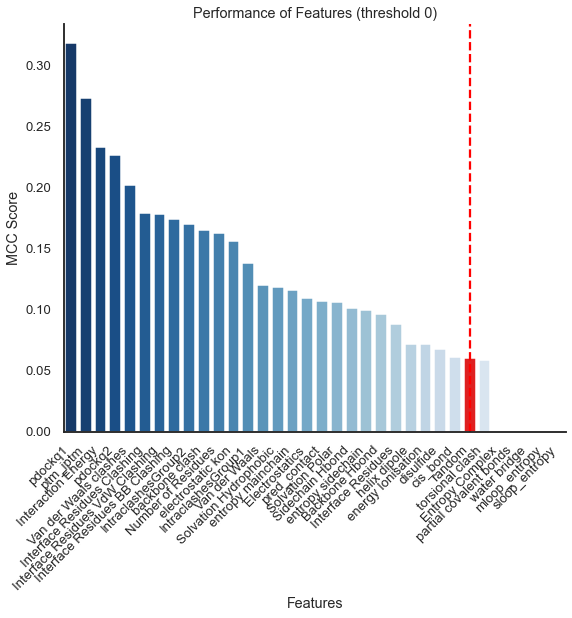

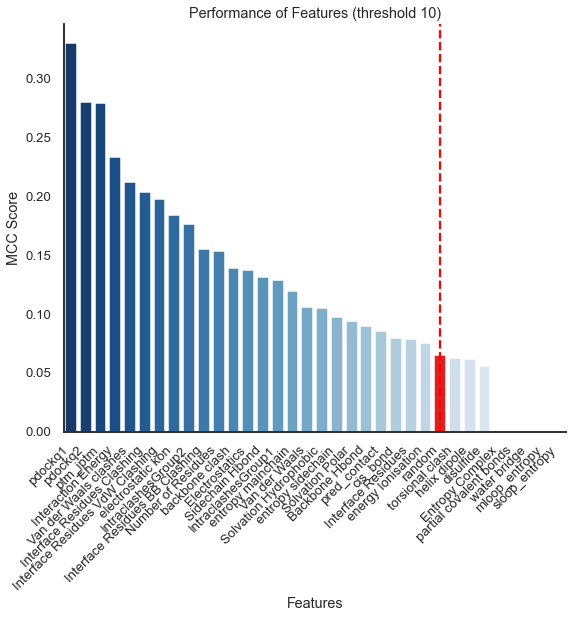

In [15]:
for threshold,dic in thresholds_features_dic.items():
    #random=np.mean([features_dic['random1'],features_dic['random2'],features_dic['random3']])
    #del features_dic['random1']; del features_dic['random2']; del features_dic['random3'];

    # Convert the dictionary into a Pandas DataFrame and sort by value in descending order
    df_tmp = pd.DataFrame(list(dic.items()), columns=["Features", "Values"]).sort_values(by="Values", ascending=False)

    # Set the x-axis label and rotate the labels for better visibility
    sns.set(rc={'figure.figsize':(9,7.5)})
    sns.set_style('white')
    sns.set_context('talk', font_scale=0.8)

    # Set the color palette with red for "random" feature and blues_r for others
    palette = {"random": "red"}
    other_palette = sns.color_palette("Blues_r", len(df_tmp))
    for i, feature in enumerate(df_tmp["Features"].tolist()):
        if feature != "random":
            palette[feature] = other_palette[i]

    # Create the bar plot
    ax = sns.barplot(x="Features", y="Values", data=df_tmp, order=df_tmp["Features"], palette=palette)
    sns.despine()
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("MCC Score")
    plt.title('Performance of Features (threshold %d)'%threshold)

    # Add a vertical dashed red line at the location of the "random" bar
    random_index = np.where(df_tmp["Features"]=="random")[0][0]
    ax.axvline(x=random_index, color="red", linestyle="--")

    plt.show()

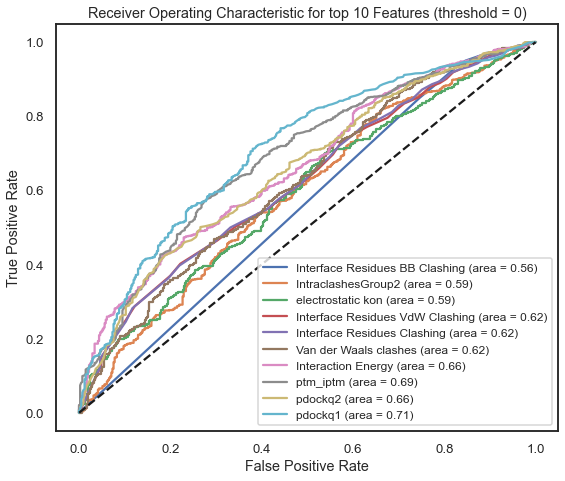

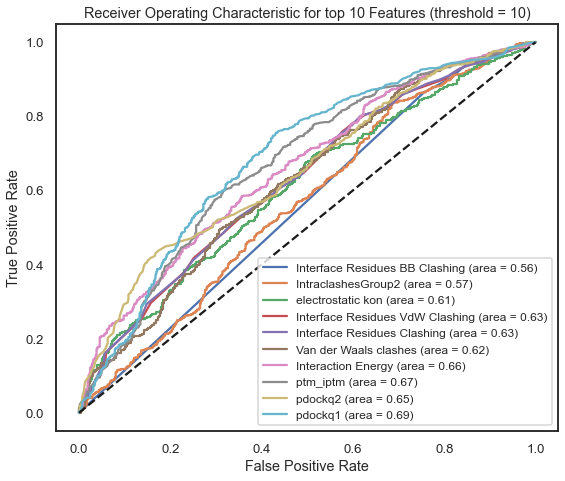

In [16]:
for threshold in [0,10]:
    best_features = sorted(thresholds_features_dic[10],key=lambda x: thresholds_features_dic[10][x])[-10:]
    df['binary_obs_contact'] = np.where(df['obs_contact'] > threshold, 1, 0)

    plt.figure()
    for feature in best_features:
        ranked_df[feature] = df[feature].rank()

        if np.corrcoef(ranked_df['binary_obs_contact'],ranked_df[feature])[0][1] > 0:
            fpr, tpr, _ = roc_curve(df['binary_obs_contact'], ranked_df[feature])
            roc_auc = auc(fpr, tpr)
        else:
            ranked_df[feature]=ranked_df[feature]*(-1)
            fpr, tpr, _ = roc_curve(df['binary_obs_contact'], ranked_df[feature])
            roc_auc = auc(fpr, tpr)    
        plt.plot(fpr, tpr, label='%s (area = %0.2f)' % (feature,roc_auc))

    plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal (random classifier)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for top 10 Features (threshold = %d)'%threshold)
    plt.legend(loc='lower right',fontsize='small')
    plt.show()

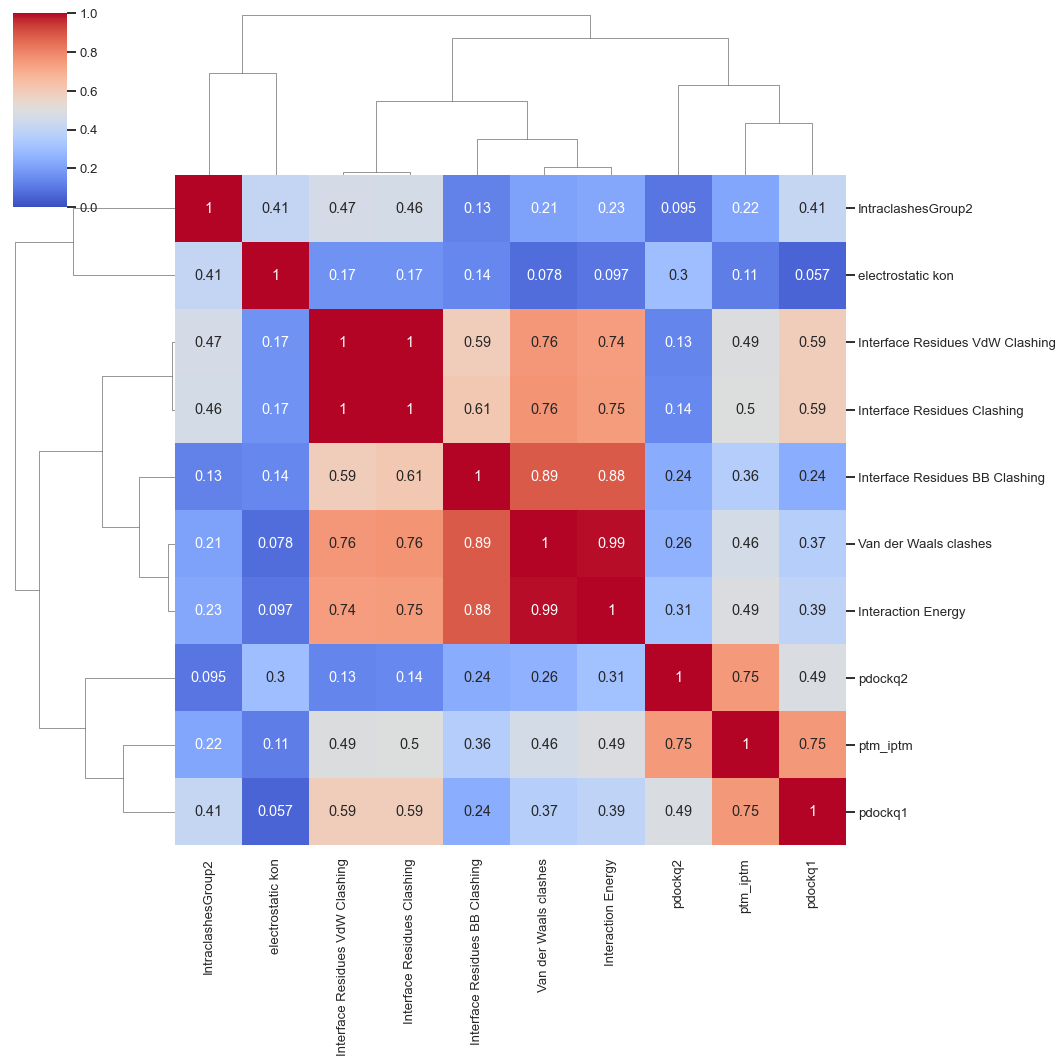

In [11]:
best_features = sorted(thresholds_features_dic[10],key=lambda x: thresholds_features_dic[10][x])[-10:]

# Calculate the correlation matrix between the features
corr_matrix = np.abs(np.corrcoef(df[best_features], rowvar=False))

# Create a hierarchical clustering plot using Seaborn
sns.clustermap(corr_matrix, cmap="coolwarm", xticklabels=df[best_features].columns, yticklabels=df[best_features].columns, annot=True, figsize=(15, 15), vmin=0, vmax=1)

***  Score distribution of structures ***

Interface Residues BB Clashing 0.15495930494133045
IntraclashesGroup2 0.1761850290961664
electrostatic kon 0.18379806578942223
Interface Residues VdW Clashing 0.19746412823894005
Interface Residues Clashing 0.20338520834360072
Van der Waals clashes 0.2114096710180099
Interaction Energy 0.23261848538077132
ptm_iptm 0.2790266631795683
pdockq2 0.27969517596622323
pdockq1 0.3294865998797709


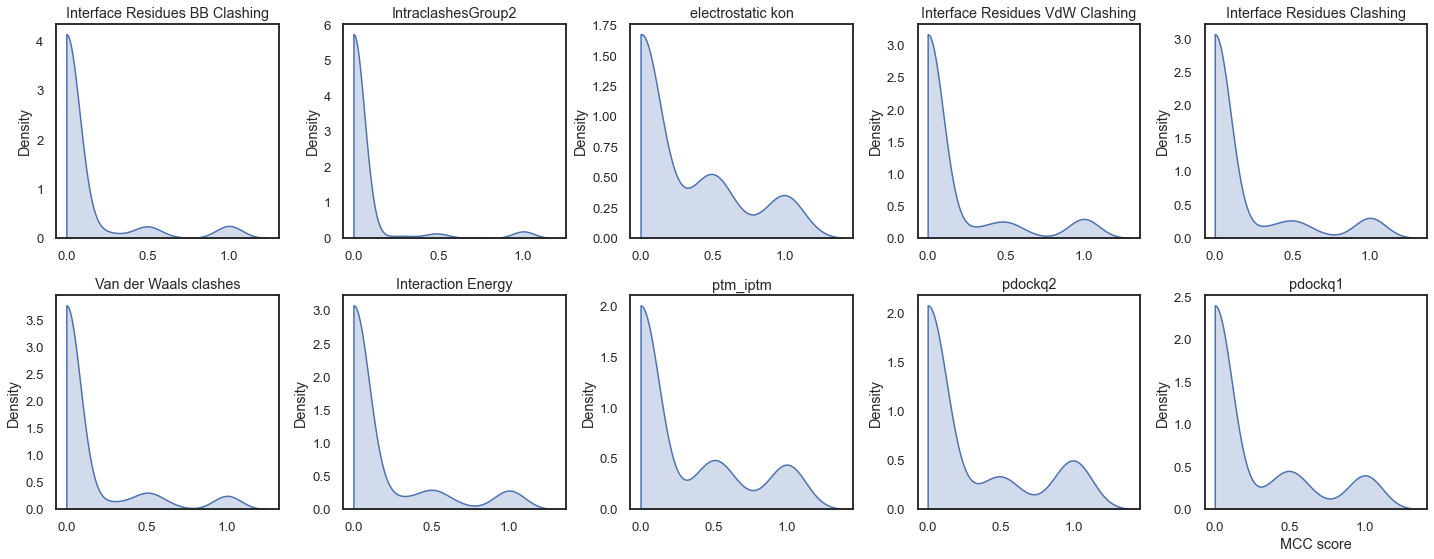

In [101]:
unique_ids = np.unique(df.pdb_id)
all_mcc=[0 for i in range(298)]
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i,feature in enumerate(best_features):
    print (feature,features_dic[feature])
    row = i // 5
    col = i % 5
    #print(thresholds_dic[feature])
    if thresholds_dic[feature][1]==1:
        binary_pred = ( ranked_df[feature] >= thresholds_dic[feature][0]).astype(int)
    else:
        binary_pred = ( ranked_df[feature] <= thresholds_dic[feature][0]).astype(int)
    mcc_scores = []
    for id in unique_ids:
        obs_contact_group = df['binary_obs_contact'][df.pdb_id == id]
        binary_pred_group = binary_pred[df.pdb_id == id]
        mcc = safe_mcc(obs_contact_group, binary_pred_group)
        mcc_scores.append(mcc)
    all_mcc=np.add(all_mcc,mcc_scores)
    ax = axs[row, col]
    sns.kdeplot(mcc_scores, shade=True,clip=(0, None),ax=ax)
    plt.xlabel('MCC score')
    ax.set_title('%s'%feature)
fig.tight_layout()

Text(0.5, 0, 'MCC score')

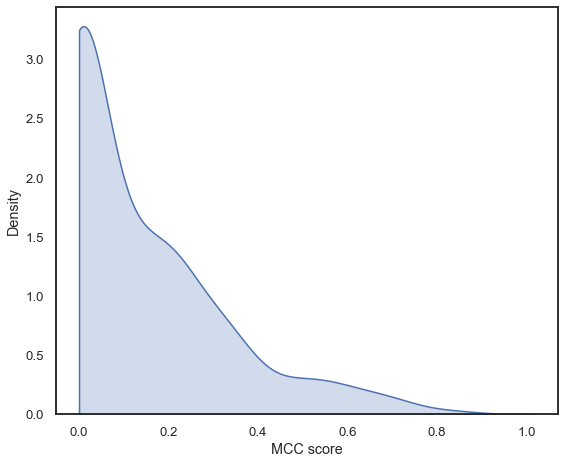

In [102]:
#to check if there are some structure that always have good results
sns.kdeplot(all_mcc/len(best_features), shade=True,clip=(0, None)) #No,it became flatten, means that no structure has same results in all features 
plt.xlabel('MCC score')

*** Check the RMSD of interacting pairs ***

In [94]:
rmsd_data = pd.read_csv('rmsds.txt',names=['pair','obs_contact','rmsd'])
rmsd_data.drop(columns=['obs_contact'],axis=1, inplace=True)
#rmsd_data['rmsd'] = np.where(rmsd_data['rmsd'] > 2, 0, 1)
def sort_ids(string):
    general, id1, general, id2 = string.split('_')
    id1, id2 = sorted([id1, id2])
    return f"{general}_{id1}_{general}_{id2}"
rmsd_data['pair'] = rmsd_data['pair'].apply(sort_ids)
rmsd_data['rmsd'] = rmsd_data['rmsd'] + 0.001 #to avoid 0 values

ranked_df['pair']=df['pair']
ranked_df['obs_contact']=df['obs_contact']
df_pos = ranked_df[ranked_df['obs_contact']>0].copy()

merged_df = pd.merge(df_pos, rmsd_data, on='pair')

How many have RMSD less than 3?  448
How many have obs_contact more than 10?  797


Text(0.5, 1.0, 'Distribution of RMSDs')

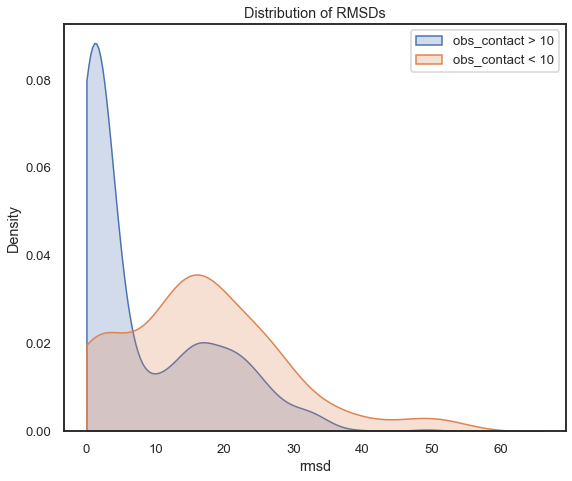

In [97]:
print ("How many have RMSD less than 3? ",len(merged_df[merged_df['rmsd']<3]))
print ("How many have obs_contact more than 10? ",len(merged_df[merged_df['obs_contact']>10]))
sns.kdeplot(merged_df['rmsd'][merged_df['obs_contact']>10], shade=True,clip=(0, None),label='obs_contact > 10')
sns.kdeplot(merged_df['rmsd'][merged_df['obs_contact']<10], shade=True,clip=(0, None),label='obs_contact < 10')
plt.legend()
plt.title('Distribution of RMSDs')
#sns.scatterplot(x='obs_contact',y='rmsd',data=merged_df)
#plt.xscale('log')

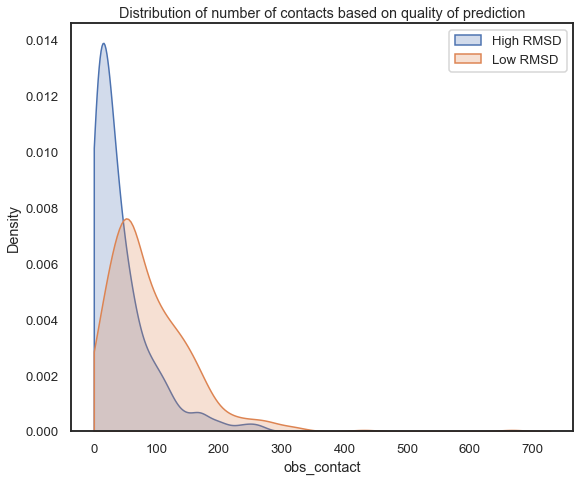

In [98]:
#print (merged_df[['pair','obs_contact']][(merged_df.obs_contact>0) & (merged_df.rmsd>3)])
plt.title('Distribution of number of contacts based on quality of prediction')
sns.kdeplot(merged_df['obs_contact'][(merged_df.obs_contact>0) & (merged_df.rmsd>3)],shade=True,clip=(0, None),label='High RMSD')
sns.kdeplot(merged_df['obs_contact'][(merged_df.obs_contact>0) & (merged_df.rmsd<=3)],shade=True,clip=(0, None),label='Low RMSD')
plt.legend()

Interface Residues BB Clashing 	 912 48
IntraclashesGroup2 	 788 172
electrostatic kon 	 643 317
Interface Residues VdW Clashing 	 741 219
Interface Residues Clashing 	 738 222
Van der Waals clashes 	 865 95
Interaction Energy 	 810 150
ptm_iptm 	 546 414
pdockq2 	 352 608
pdockq1 	 690 270


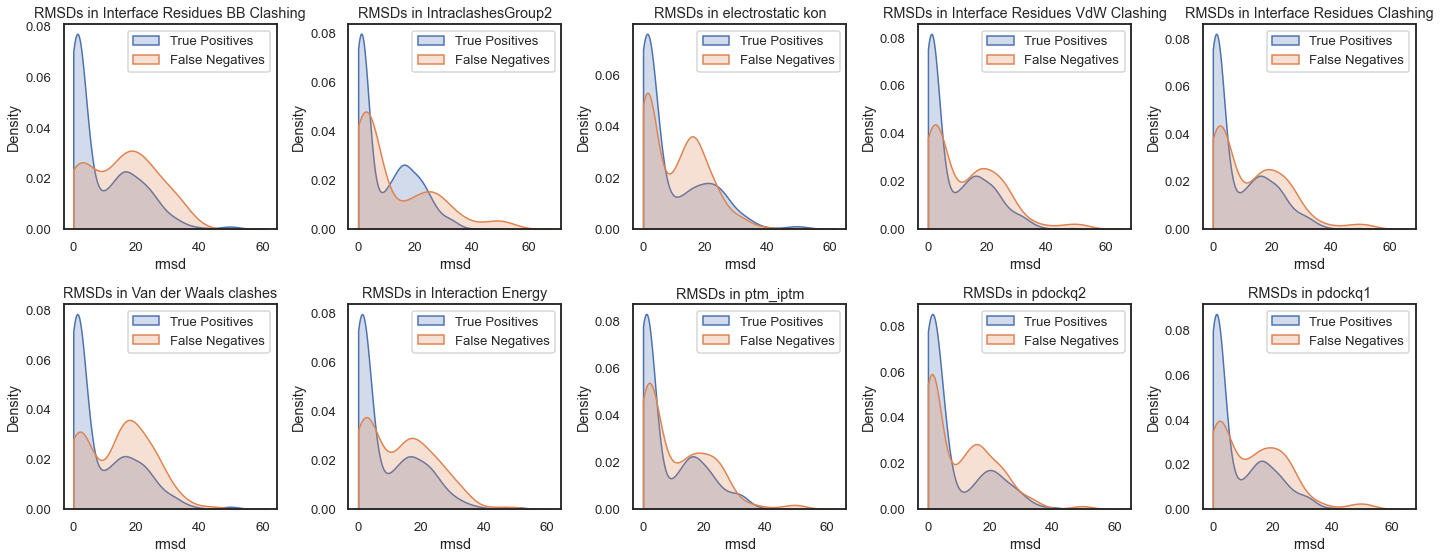

In [99]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i,feature in enumerate(best_features):
    row = i // 5
    col = i % 5
    #print(thresholds_dic[feature])
    if thresholds_dic[feature][1]==1:
        binary_pred = (merged_df[feature] >= thresholds_dic[feature][0]).astype(int)
    else:
        binary_pred = (merged_df[feature] <= thresholds_dic[feature][0]).astype(int)
    TP_rmsds=merged_df['rmsd'][binary_pred==1]
    FN_rmsds=merged_df['rmsd'][binary_pred==0]
    
    print(feature, '\t',len(binary_pred[binary_pred==1]),len(binary_pred[binary_pred==0]))
    ax = axs[row, col]
    #sns.violinplot(y=merged_df['rmsd'], x=binary_pred, ax=ax)
    sns.kdeplot(merged_df['rmsd'][binary_pred==1], shade=True, label='True Positives',clip=(0, None),ax=ax)
    sns.kdeplot(merged_df['rmsd'][binary_pred==0], shade=True, label='False Negatives',clip=(0, None),ax=ax)
    ax.set_title('RMSDs in %s'%feature)
    ax.legend()
fig.tight_layout()